In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# %pip install -e .

HERE = Path.cwd().resolve()
REPO = HERE.parent
SRC  = REPO / "src"

# make 'boreas' importable from source tree
if (SRC / "boreas").exists():
    sys.path.insert(0, str(SRC))

from boreas import ModelParams, MassLoss, Fractionation
from boreas.flow_solutions import FlowSolutions as FS

try:
    from plots import Plots # if plots/ has an init.py file
except ImportError:
    from plots.plots import Plots

#### Loader for M-R .ddat files

In [2]:
class ModelDataLoader:
    def __init__(self, base_path: Path, params: ModelParams):
        self.base_path = Path(base_path)
        self.params = params

    def load_single_ddat_file(self, ddat_filename):
        """
        Load a single .ddat file by name and return arrays for mass, radius, and temperature.
        """
        p = self.base_path / ddat_filename
        
        rows = []
        
        with p.open("r") as f:
            for line in f:
                s = line.strip()
                if not s or s.startswith("#"):
                    continue
                row = [float(x) for x in s.split()]
                if row[1] == -1.0:
                    continue
                rows.append(row)
                
        if not rows:
            raise ValueError(f"No valid rows in {p}")

        data = np.array(rows, dtype=float)
        mass_me     = data[:, 0]
        radius_re   = data[:, 1]
        teq_k       = data[:, 2]
        mass_g      = mass_me  * self.params.mearth
        radius_c    = radius_re* self.params.rearth
        return mass_g, radius_c, teq_k

#### Grids and composition: H₂ + H₂O only

In [3]:
params        = ModelParams()

# set *only* H2 and H2O; auto-normalize so you can give any proportions
base = Path("/Users/mvalatsou/PhD/Repos/MR_perplex/OUTPUT/paper")
out_dir = Path("/Users/mvalatsou/PhD/Repos/MR_perplex/OUTPUT/paper_rerun/XUV_filter")

params.set_composition({"H2": 0.8, "H2O": 0.2}, auto_normalize=True)
ddat_file = "3HHe_20H2O_subNeptune.ddat"
csv_path = HERE / "plots_T-FXUV.csv"

params        = ModelParams()
mass_loss     = MassLoss(params)
fractionation = Fractionation(params)
loader        = ModelDataLoader(base, params)

mass, radius, Teq = loader.load_single_ddat_file(ddat_file)
print(mass.shape, radius.shape, Teq.shape)

(27,) (27,) (27,)


#### Test: plot the 2 functions that need to cross -> root of RXUV

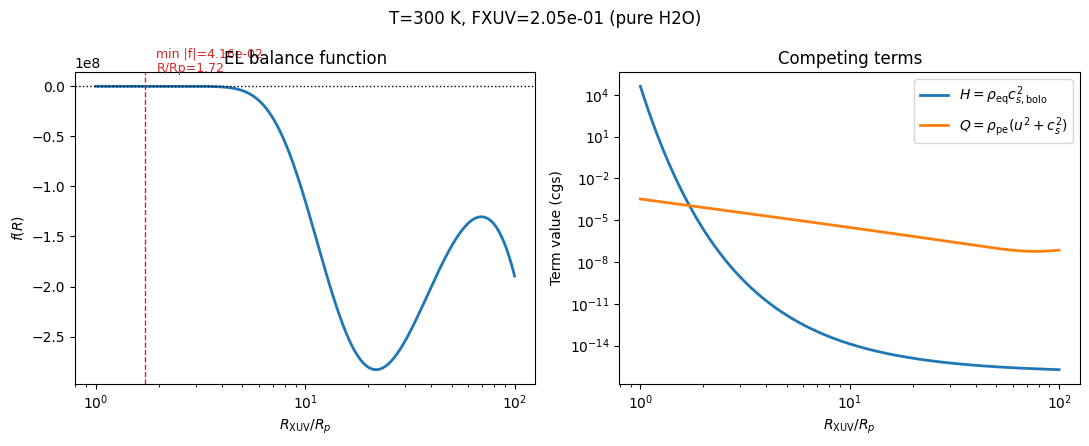

min |f| = 0.041635063647731056


In [4]:
########## TEST

def scan_EL_function(mass_loss, params, m_p, r_p, T_eq, Rmax_mult=100, n=400):
    """
    Scan f(R) over [1.001 Rp, Rmax_mult*Rp] for one planet.
    Returns DataFrame with columns: R, R_over_Rp, f, H, Q, cs_out, u_launch, ts_ratio
    """
    G, k_b, m_H = params.G, params.k_b, params.m_H
    FXUV = params.FXUV
    E_photon = params.E_photon
    FXUV_photon = FXUV / E_photon

    # bolometric anchor at Rp
    mu_bolo = params.get_mmw_bolometric()
    cs_bolo = np.sqrt(k_b * T_eq / (m_H * mu_bolo))
    kappa_bolo = params.kappa_p_all
    rho_bolo = G * m_p / r_p**2 / (kappa_bolo * cs_bolo**2)

    R_min = r_p * 1.001
    R_max = r_p * float(Rmax_mult)
    R = np.geomspace(R_min, R_max, int(n))

    rows = []
    for Rx in R:
        try:
            diff, ts_ratio, rho_eq, rho_pe = mass_loss.compare_densities_EL(
                Rx, rho_bolo, r_p, m_p, cs_bolo, FXUV_photon
            )
            # consistent cs_out and u_launch at Rx
            cs_out = mass_loss.compute_sound_speed(Rx, m_p)
            cs_out = min(cs_out, 1.2e6)
            Rs = params.G * m_p / (2.0 * cs_out**2)
            if Rx <= Rs:
                u_launch = FS.get_parker_wind_single(Rx, cs_out, Rs)
            else:
                u_launch = cs_out

            H = rho_eq * cs_bolo**2
            Q = rho_pe * (u_launch**2 + cs_out**2)
            rows.append([Rx, Rx/r_p, diff, H, Q, cs_out, u_launch, ts_ratio])
        except Exception:
            rows.append([Rx, Rx/r_p, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])

    return pd.DataFrame(rows, columns=["R","R_over_Rp","f","H","Q","cs_out","u_launch","ts_ratio"])

def plot_EL_scan(df, title=None):
    fig, ax = plt.subplots(1,2, figsize=(11,4.5))

    # f(R)
    ax[0].semilogx(df["R_over_Rp"], df["f"], lw=2)
    ax[0].axhline(0, color="k", lw=1, ls=":")
    finite = df[np.isfinite(df["f"])]
    if not finite.empty:
        i_best = np.abs(finite["f"]).idxmin()
        ax[0].axvline(finite.loc[i_best,"R_over_Rp"], color="C3", ls="--", lw=1)
        ax[0].annotate(f"min |f|={abs(finite.loc[i_best,'f']):.2e}\nR/Rp={finite.loc[i_best,'R_over_Rp']:.2f}",
                       xy=(finite.loc[i_best,"R_over_Rp"], 0), xytext=(8,10),
                       textcoords="offset points", fontsize=9, color="C3")
    ax[0].set_xlabel(r"$R_{\rm XUV}/R_p$")
    ax[0].set_ylabel(r"$f(R)$")
    ax[0].set_title("EL balance function")

    # H vs Q
    ax[1].loglog(df["R_over_Rp"], df["H"], label=r"$H=\rho_{\rm eq}c_{s,\rm bolo}^2$", lw=2)
    ax[1].loglog(df["R_over_Rp"], df["Q"], label=r"$Q=\rho_{\rm pe}(u^2+c_s^2)$", lw=2)
    ax[1].set_xlabel(r"$R_{\rm XUV}/R_p$")
    ax[1].set_ylabel("Term value (cgs)")
    ax[1].legend()
    ax[1].set_title("Competing terms")

    if title:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()
    
### ---

df_fxuv  = pd.read_csv(csv_path)

if "teq" not in df_fxuv.columns or "fxuv" not in df_fxuv.columns:
    raise ValueError("CSV must have columns 'teq' and 'fxuv'.")

T_target = float(Teq[0])
# nearest Teq in the CSV (in case of rounding)
i_T = np.abs(df_fxuv["teq"].values - T_target).argmin()
FXUV_val = float(df_fxuv.loc[i_T, "fxuv"])

params.update_param("FXUV", FXUV_val)

# scan & plot
df_scan = scan_EL_function(mass_loss, params, float(mass[0]), float(radius[0]), T_target, Rmax_mult=100, n=400)
plot_EL_scan(df_scan, title=f"T={T_target:.0f} K, FXUV={FXUV_val:.2e} (pure H2O)")

### ----

finite = df_scan[np.isfinite(df_scan["f"])]
min_abs_f = float(np.abs(finite["f"]).min()) if not finite.empty else np.inf
print("min |f| =", min_abs_f)
